## Stock Price Prediction using LSTM and ARIMAX with Feature Engineering & Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Configure Yahoo Finance data source
# Download historical stock data
ticker = "GOOGL"
start_date = "2018-01-01"
end_date = "2023-10-31"

df = yf.download(ticker, start=start_date, end=end_date, progress=False)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000
...,...,...,...,...,...,...
2023-10-24,137.830002,139.360001,137.419998,138.809998,138.809998,44814300
2023-10-25,128.160004,128.309998,125.070000,125.610001,125.610001,84366200
2023-10-26,123.269997,124.330002,121.269997,122.279999,122.279999,57061100


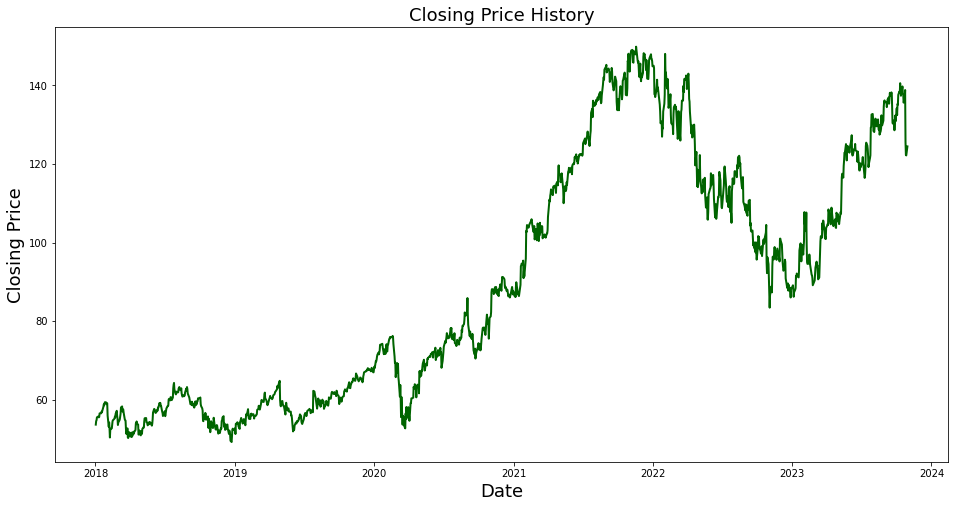

In [3]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History', fontsize=18)
plt.plot(df['Close'], linewidth=2, color='Darkgreen')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price', fontsize=18)
plt.show()

In [4]:
# Feature Engineering
df['Return'] = df['Close'].pct_change() # Simple daily return
df['Moving_Avg_5'] = df['Close'].rolling(window=5).mean() # 5-day moving average
df['Moving_Avg_10'] = df['Close'].rolling(window=10).mean() # 10-day moving average
df['Moving_STD_10'] = df['Close'].rolling(window=10).std() # 10-day moving standard deviation

# Replace NA values with 0
df.fillna(0, inplace=True)

df.head(30)

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-02,52.651001,53.799000,52.651001,53.660500,53.660500,31766000,0.000000,0.000000,0.000000,0.000000
2018-01-03,53.696499,54.805000,53.671501,54.576000,54.576000,31318000,0.017061,0.000000,0.000000,0.000000
2018-01-04,54.854500,55.203999,54.713001,54.787998,54.787998,26052000,0.003884,0.000000,0.000000,0.000000
2018-01-05,55.172501,55.679001,55.090000,55.514500,55.514500,30250000,0.013260,0.000000,0.000000,0.000000
2018-01-08,55.549999,55.958000,55.500000,55.710499,55.710499,24644000,0.003531,54.849899,0.000000,0.000000
2018-01-09,55.922001,55.922001,55.410000,55.639500,55.639500,26808000,-0.001274,55.245699,0.000000,0.000000
2018-01-10,55.349998,55.639000,55.199001,55.507000,55.507000,20734000,-0.002381,55.431899,0.000000,0.000000
2018-01-11,55.615501,55.742500,55.324001,55.602501,55.602501,22424000,0.001721,55.594800,0.000000,0.000000
2018-01-12,55.505001,56.564999,55.400501,56.532501,56.532501,38586000,0.016726,55.798400,0.000000,0.000000


In [5]:
# Removing first 9 rows since they contain 0 values
df1 = df[9:]

df1.head()

,Open,High,Low,Close,Adj Close,Volume,Return,Moving_Avg_5,Moving_Avg_10,Moving_STD_10
Date,,,,,,,,,,
2018-01-16,57.015499,57.444000,56.3330,56.535000,56.535000,36462000,0.000044,55.963300,55.40660,0.873630
2018-01-17,56.818001,56.966000,56.1745,56.955002,56.955002,27830000,0.007429,56.226401,55.73605,0.755158
2018-01-18,56.967499,57.029499,56.2230,56.798500,56.798500,27498000,-0.002748,56.484701,55.95830,0.700913
2018-01-19,56.901501,57.188999,56.6250,57.174999,57.174999,30552000,0.006629,56.799200,56.19700,0.663533
2018-01-22,57.191002,58.344002,57.0910,58.208000,58.208000,29550000,0.018067,57.134300,56.46635,0.870204


In [6]:
# Define the features and the target variable
features = ['Open', 'High', 'Low', 'Return', 'Moving_Avg_5', 'Moving_Avg_10', 'Moving_STD_10']

X = df1[features]
y = df1['Close']

# Feature Scaling
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.values.reshape(-1,1))

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)

In [8]:
# Use auto_arima to find the best model for the data
stepwise_model = auto_arima(y_train,
                            exogenous = X_train,
                            start_p=1, start_q=1,
                            max_p=3, max_q=3,
                            m=12, start_P=0, seasonal=False,
                            d=1, D=1, trace=True,
                            error_action='ignore', suppress_warnings=True,
                            stepwise=True)

# Fit ARIMAX model
best_arimax_model = SARIMAX(y_train,
                exog = X_train,
                order=stepwise_model.order)
best_arimax_fit = best_arimax_model.fit(disp=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6198.781, Time=0.18 sec


 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6193.752, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6199.065, Time=0.58 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6198.784, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6194.961, Time=0.15 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6197.599, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6195.494, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-6200.138, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-6198.713, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-6199.899, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-6199.851, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6197.900, Time=0.41 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.211 seconds


In [9]:
# Make predictions
arimax_predictions = best_arimax_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

In [10]:
# Denormalize predictions
arimax_pred_inv = target_scaler.inverse_transform(np.array(arimax_predictions).reshape(-1, 1))

# Denormalize original test_data
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [11]:
# Calculate Evaluation Metrics for ARIMA model
arimax_mse = mean_squared_error(y_test_inv, arimax_pred_inv)
arimax_rmse = np.sqrt(arimax_mse)    
arimax_mae = mean_absolute_error(y_test_inv, arimax_pred_inv)
arimax_r2 = r2_score(y_test_inv, arimax_pred_inv)

print("ARIMAX Model Evaluation Metrics")
print("-------------------------------")
print('MSE: {:.4f}'.format(arimax_mse))
print('RMSE: {:.4f}'.format(arimax_rmse))
print('MAE: {:.4f}'.format(arimax_mae))
print('R2: {:.4f}'.format(arimax_r2))

ARIMAX Model Evaluation Metrics
-------------------------------
MSE: 0.8467
RMSE: 0.9202
MAE: 0.7725
R2: 0.9968


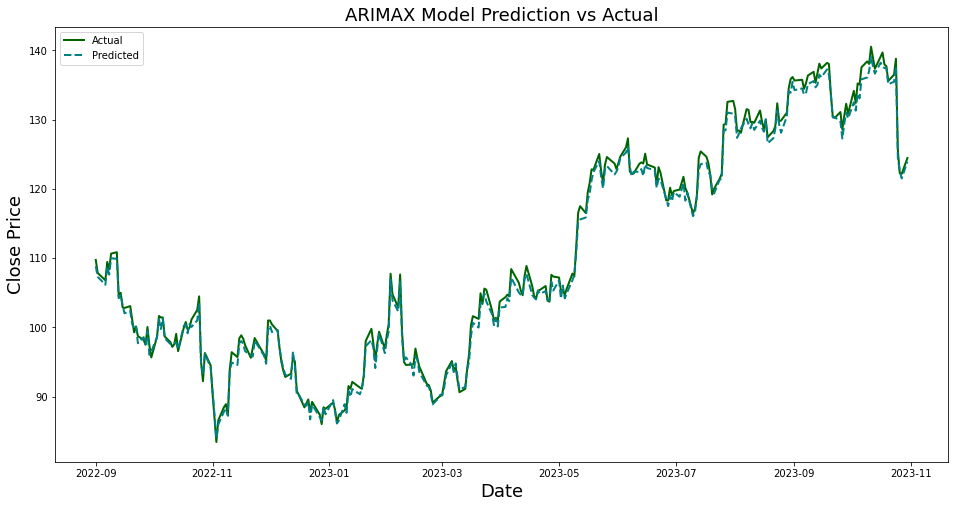

In [12]:
# Plot the predictions of ARIMAX model
plt.figure(figsize=(16,8))
plt.title('ARIMAX Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkgreen', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test):], arimax_pred_inv, linewidth=2, color='teal', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

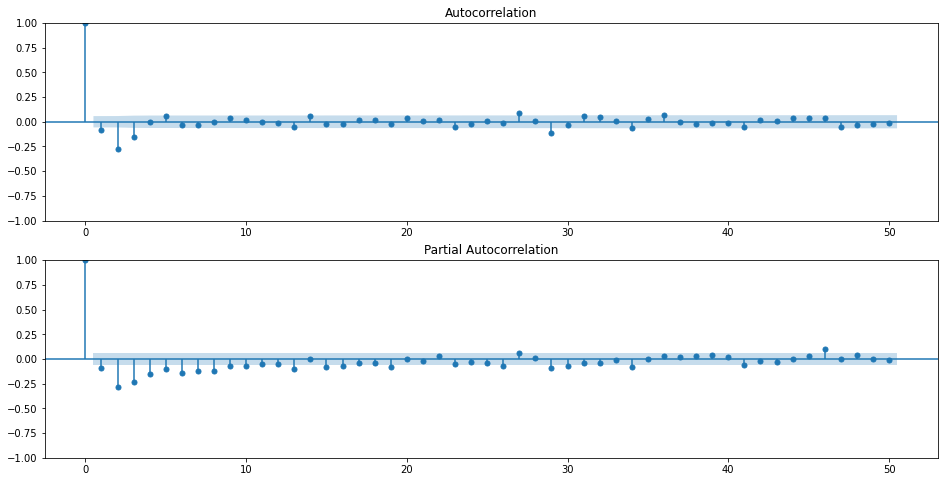

In [13]:
# ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16,8))
plot_acf(best_arimax_fit.resid, lags=50, ax=ax1)
plot_pacf(best_arimax_fit.resid, lags=50, ax=ax2)
plt.show()

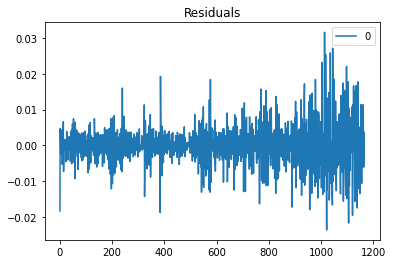

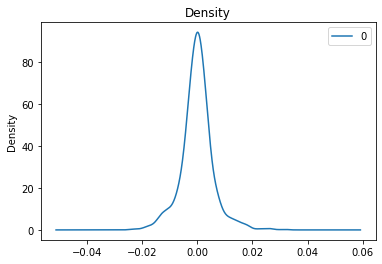

<Figure size 1152x720 with 0 Axes>

In [14]:
# Residual Errors
residuals = pd.DataFrame(best_arimax_fit.resid)
residuals.plot(title="Residuals")
residuals.plot(kind='kde', title='Density')
plt.figure(figsize=(16,10))
plt.show()

In [15]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1166, 7)
y_train shape:  (1166, 1)
X_test shape:  (292, 7)
y_test shape:  (292, 1)


In [16]:
# Since LSTM expects a 3D array as input, we need to reshape the data
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [17]:
print("X_train_lstm shape: ", X_train_lstm.shape)
print("X_test_lstm shape: ", X_test_lstm.shape)

X_train_lstm shape:  (1166, 1, 7)
X_test_lstm shape:  (292, 1, 7)


In [18]:
# Create a Estimator class for LSTM model
class LSTMEstimator(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam'):
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add(LSTM(100, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(1))
        self.model.compile(optimizer=self.optimizer, loss='mse')

    def fit(self, X, y):
        self.model.fit(X, y, epochs=100, batch_size=64, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()
    
# Create the LSTM model
lstm_model = LSTMEstimator()
lstm_model.fit(X_train_lstm, y_train)

# Predict using the LSTM model
lstm_predictions = lstm_model.predict(X_test_lstm)

# Denormalize the predictions
lstm_predictions_inv = target_scaler.inverse_transform(lstm_predictions.reshape(-1, 1))
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 [==============================] - 1s 2ms/step


In [19]:
# Calculate Evaluation Metrics for LSTM model
lstm_mse = mean_squared_error(y_test_inv, lstm_predictions_inv)
lstm_rmse = np.sqrt(lstm_mse)    
lstm_mae = mean_absolute_error(y_test_inv, lstm_predictions_inv)
lstm_r2 = r2_score(y_test_inv, lstm_predictions_inv)

print("LSTM Model Evaluation Metrics")
print("-------------------------------")
print('MSE: {:.4f}'.format(lstm_mse))
print('RMSE: {:.4f}'.format(lstm_rmse))
print('MAE: {:.4f}'.format(lstm_mae))
print('R2: {:.4f}'.format(lstm_r2))

LSTM Model Evaluation Metrics
-------------------------------
MSE: 1.8421
RMSE: 1.3572
MAE: 1.0735
R2: 0.9929


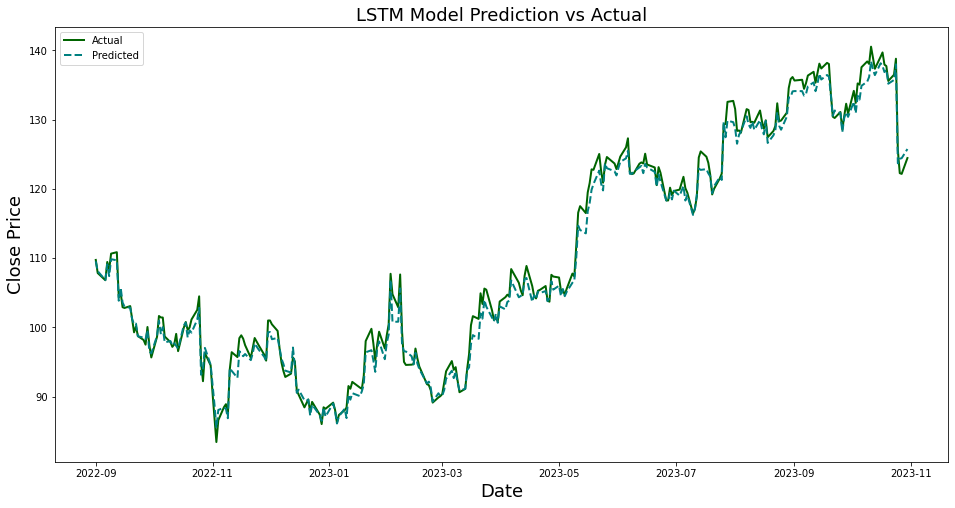

In [20]:
# Plot the predictions of LSTM model
plt.figure(figsize=(16,8))
plt.title('LSTM Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test_inv):], y_test_inv, linewidth=2, color='darkgreen', label='Actual', linestyle='solid')
plt.plot(df1.index[-len(y_test_inv):], lstm_predictions_inv, linewidth=2, color='teal', label='Predicted', linestyle='dashed')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [21]:
# LSTM model with hyperparameter tuning
# Define the parameter grid
param_grid = {'optimizer': ['Adam']}

# Grid search on LSTM
grid = GridSearchCV(estimator=LSTMEstimator(), param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
grid_lstm = grid.fit(X_train_lstm, y_train)

# Print the best parameters
print("Best parameters: ", grid_lstm.best_params_)
print("Best score: ", grid_lstm.best_score_)
print("Best estimator: ", grid_lstm.best_estimator_)

# Using the best estimator for LSTM from the grid search
best_lstm_model = grid_lstm.best_estimator_

# Predicting the test data
pred_best_lstm = best_lstm_model.predict(X_test_lstm)

# Inverse transform the predictions
pred_best_lstm_inv = target_scaler.inverse_transform(pred_best_lstm.reshape(-1,1))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters:  {'optimizer': 'Adam'}
Best score:  0.9836075383413758
Best estimator:  LSTMEstimator(optimizer='Adam')
10/10 [==============================] - 0s 1ms/step


In [22]:
# Calculate the Evaluation Metrics for LSTM model with Hyperparameter Tuning
lstm_tuned_mse = mean_squared_error(y_test_inv, pred_best_lstm_inv)
lstm_tuned_rmse = np.sqrt(lstm_tuned_mse)
lstm_tuned_mae = mean_absolute_error(y_test_inv, pred_best_lstm_inv)
lstm_tuned_r2 = r2_score(y_test_inv, pred_best_lstm_inv)

print("LSTM Model with Hyperparameter Tuning")
print("=====================================")
print('MSE: {:.4f}'.format(lstm_tuned_mse))
print('RMSE: {:.4f}'.format(lstm_tuned_rmse))
print('MAE: {:.4f}'.format(lstm_tuned_mae))
print('R2: {:.4f}'.format(lstm_tuned_r2))

LSTM Model with Hyperparameter Tuning
MSE: 1.2000
RMSE: 1.0954
MAE: 0.9008
R2: 0.9954


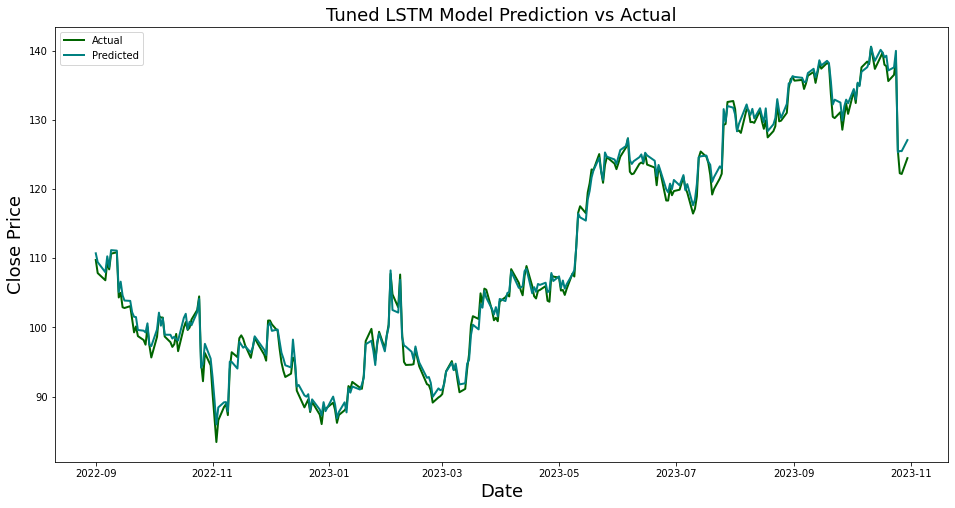

In [23]:
# Plot the predictions of LSTM model with Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkgreen', label='Actual')
plt.plot(df1.index[-len(y_test):], pred_best_lstm_inv, linewidth=2, color='teal', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [24]:
# Stacked LSTM-ARIMAX Model
stacked_predictions = np.column_stack((arimax_predictions, lstm_predictions))

# Create a meta model to predict the stacked predictions
final_regressor = LinearRegression().fit(stacked_predictions, y_test)

# Predict on the test data
final_pred = final_regressor.predict(stacked_predictions)

# Denormalize the predicted values
final_pred_inv = target_scaler.inverse_transform(final_pred.reshape(-1, 1))

In [25]:
# Calculate the Evaluation Metrics for Stacked model
stacked_mse = mean_squared_error(y_test_inv, final_pred_inv)
stacked_rmse = np.sqrt(stacked_mse)
stacked_mae = mean_absolute_error(y_test_inv, final_pred_inv)
stacked_r2 = r2_score(y_test_inv, final_pred_inv)

print('LSTM-ARIMAX Stacked Model Evaluation Metrics')
print('--------------------------------------------')
print('MSE: {:.4f}'.format(stacked_mse))
print('RMSE: {:.4f}'.format(stacked_rmse))
print('MAE: {:.4f}'.format(stacked_mae))
print('R2: {:.4f}'.format(stacked_r2))

LSTM-ARIMAX Stacked Model Evaluation Metrics
--------------------------------------------
MSE: 0.3518
RMSE: 0.5932
MAE: 0.4722
R2: 0.9987


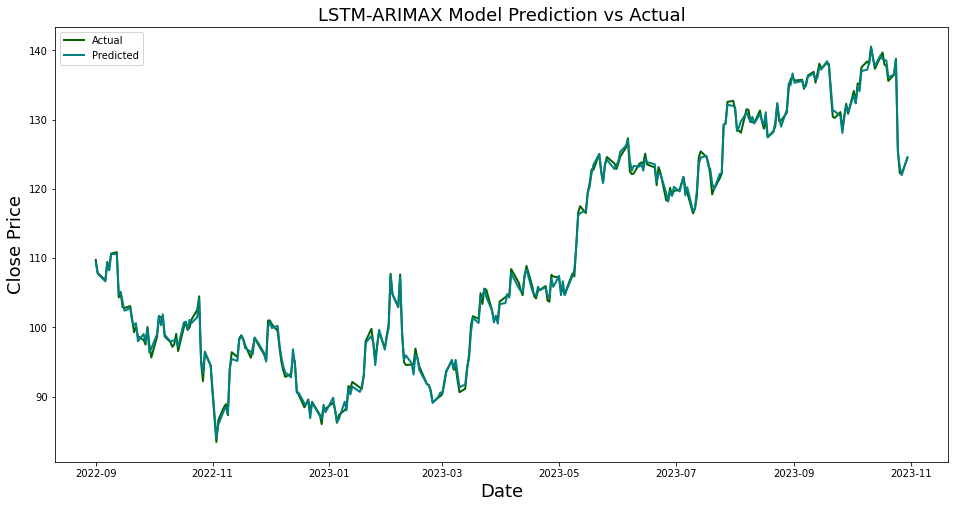

In [26]:
# Plot the predictions of LSTM model without Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('LSTM-ARIMAX Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkgreen', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_inv, linewidth=2, color='teal', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [27]:
# Stacked LSTM-ARIMAX Model with Hyperparameter Tuning
stacked_predictions_tuned_2 = np.column_stack((arimax_predictions, pred_best_lstm))

# Train a final regressor based on the stacked predictions
final_regressor_tuned_2 = LinearRegression().fit(stacked_predictions_tuned_2, y_test)

# Predict on the test data
final_pred_tuned_2 = final_regressor_tuned_2.predict(stacked_predictions_tuned_2)

# Denormalize the predicted values
final_pred_tuned_2_inv = target_scaler.inverse_transform(final_pred_tuned_2.reshape(-1,1))

In [28]:
# Calculate the Evaluation Metrics for Stacked model
final_tuned_mse_2 = mean_squared_error(y_test_inv, final_pred_tuned_2_inv)
final_tuned_rmse_2 = np.sqrt(mean_squared_error(y_test_inv, final_pred_tuned_2_inv))
final_tuned_mae_2 = mean_absolute_error(y_test_inv, final_pred_tuned_2_inv)
final_tuned_r2_2 = r2_score(y_test_inv, final_pred_tuned_2_inv)

print("LSTM-ARIMAX Stacked Model with Hyperparameter Tuning")
print("=====================================================")
print("MSE: {:.4f}".format(final_tuned_mse_2))
print("RMSE: {:.4f}".format(final_tuned_rmse_2))
print("MAE: {:.4f}".format(final_tuned_mae_2))
print("R2: {:.4f}".format(final_tuned_r2_2))

LSTM-ARIMAX Stacked Model with Hyperparameter Tuning
MSE: 0.3527
RMSE: 0.5939
MAE: 0.4724
R2: 0.9986


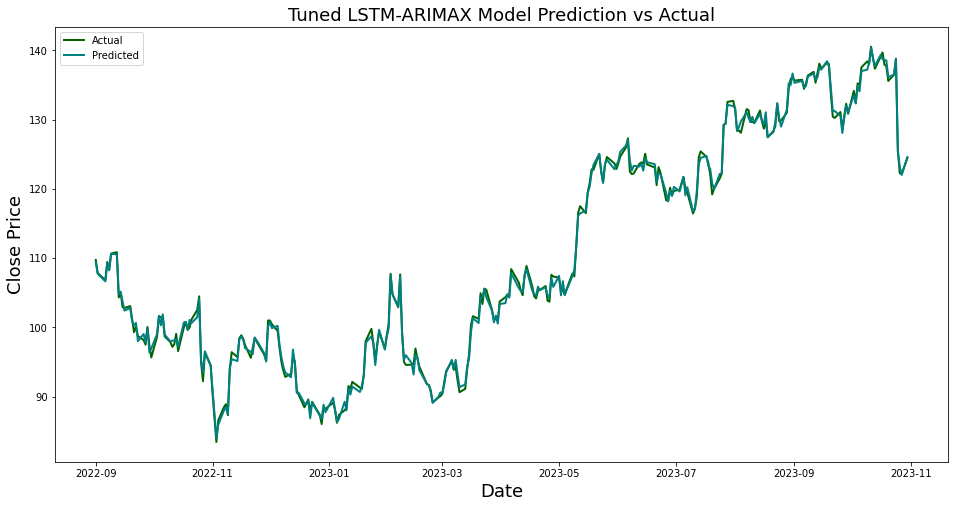

In [29]:
# Plot the predictions of stacked model 2 Hyperparameter tuning
plt.figure(figsize=(16,8))
plt.title('Tuned LSTM-ARIMAX Model Prediction vs Actual', fontsize=18)
plt.plot(df1.index[-len(y_test):], y_test_inv, linewidth=2, color='darkgreen', label='Actual')
plt.plot(df1.index[-len(y_test):], final_pred_tuned_2_inv, linewidth=2, color='teal', label='Predicted')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.legend(loc='best')
plt.show()

In [30]:
# Build a dataframe with actual and predicted prices
df_pred = pd.DataFrame({'Date': df1.index[-len(y_test):],'Actual': y_test_inv.flatten(), 'LSTM': lstm_predictions_inv.flatten(), 'ARIMAX': arimax_pred_inv.flatten(), 'Tuned LSTM': pred_best_lstm_inv.flatten(), 'LSTM-ARIMAX': final_pred_inv.flatten(), 'Tuned LSTM-ARIMAX': final_pred_tuned_2_inv.flatten()})
df_pred.tail(20)

,Date,Actual,LSTM,ARIMAX,Tuned LSTM,LSTM-ARIMAX,Tuned LSTM-ARIMAX
272,2023-10-03,132.429993,130.944366,131.311358,132.937531,132.341736,132.329407
273,2023-10-04,135.240005,133.460083,133.739760,135.368835,134.800411,134.806407
274,2023-10-05,135.070007,132.909943,133.076198,134.878830,134.111964,134.105639
275,2023-10-06,137.580002,134.900391,135.842147,136.944885,137.018272,137.023448
276,2023-10-09,138.419998,135.501434,136.096433,137.604645,137.234873,137.227216
277,2023-10-10,138.059998,136.176849,137.044089,138.344940,138.231410,138.222451
278,2023-10-11,140.550003,138.443359,139.148056,140.570709,140.351089,140.352151
279,2023-10-12,138.970001,137.257446,137.712905,139.447495,138.861645,138.845236
280,2023-10-13,137.360001,136.445511,136.662890,138.519958,137.765160,137.757225
281,2023-10-16,139.100006,138.156097,138.234239,140.117065,139.346086,139.356744


In [31]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price = lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (LSTM Model):")
for i, price in enumerate(predicted_prices_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 29ms/step
Predicted Closing Prices for the Next 2 Days (LSTM Model):
Day 1:125.763
Day 2:122.161


In [32]:
# Take the last day of data for predictions
last_features = X_scaled[-1:]

predicted_prices_best_lstm = []

# Predicting stock prices for the next 2 days
for _ in range(2):
    # Prepare the last features for LSTM input shape
    last_features_lstm = last_features.reshape(1, 1, X_train_lstm.shape[2])
    
    # Predicting the next day stock price using the last feature data
    predicted_price_best_lstm = best_lstm_model.predict(last_features_lstm)
    
    # Reshape the predicted price for inverse scaling
    predicted_price_reshaped = predicted_price_best_lstm.reshape(-1, 1)
    
    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(predicted_price_reshaped)[0][0]
    predicted_prices_best_lstm.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        predicted_price_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (predicted_price_reshaped[0, 0] - last_features[0, 3]) / last_features[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features[0, 4:6], predicted_price_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features[0, 5:], predicted_price_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features[0, 6:], predicted_price_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features = new_features

print("Predicted Closing Prices for the Next 2 Days (Best LSTM Model):")
for i, price in enumerate(predicted_prices_best_lstm):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 46ms/step
Predicted Closing Prices for the Next 2 Days (Best LSTM Model):
Day 1:127.072
Day 2:124.548


In [33]:
last_features = X_scaled[-1:]

# Predict stock prices using the ARIMAX model for the next 2 days
last_features_arimax = last_features.copy()

future_exog_day1 = last_features_arimax.copy()
future_exog_day2 = last_features_arimax.copy()  # Modify this with estimated values for day 2

# Combine the exogenous variables for both days
future_exog = np.vstack([future_exog_day1, future_exog_day2])

# Forecast the next 2 days
forecasted_prices_arimax = best_arimax_fit.forecast(steps=2, exog=future_exog)

# Convert the forecasted prices to a NumPy array and then reshape
forecasted_prices_arimax_np = np.array(forecasted_prices_arimax)
forecasted_prices_arimax_reshaped = forecasted_prices_arimax_np.reshape(-1, 1)

# Inverse transform the forecasted prices
forecasted_prices_arimax_inv = target_scaler.inverse_transform(forecasted_prices_arimax_reshaped)

# Print the predicted prices for the next 2 days
print("Predicted Closing Prices for the Next 2 Days (ARIMAX Model):")
for i, price in enumerate(forecasted_prices_arimax_inv):
    print(f"Day {i+1}: {price[0]:.3f}")

Predicted Closing Prices for the Next 2 Days (ARIMAX Model):
Day 1: 124.015
Day 2: 123.919


In [34]:
last_features = X_scaled[-1:]

# Predict stock prices using the Stacked model for the next 2 days
predicted_prices_stacked = []

last_features_stacked = last_features.copy()

future_exog_day1 = last_features_arimax.copy()
future_exog_day2 = last_features_arimax.copy()
future_exog_data = [future_exog_day1, future_exog_day2]

for i in range(2):
    # Predict using LSTM model
    last_features_stacked_lstm = last_features_stacked.reshape(1, 1, X_train_lstm.shape[2])
    predicted_price_stacked_lstm = lstm_model.predict(last_features_stacked_lstm)

    # Predict using ARIMAX model
    future_exog = np.vstack(future_exog_data[i])
    forecasted_price_stacked_arimax = best_arimax_fit.forecast(steps=1, exog=future_exog)

    # Combine the predictions
    stacked_predictions = np.column_stack((forecasted_price_stacked_arimax, predicted_price_stacked_lstm))

    # Predict using the final regressor
    final_pred_stacked = final_regressor.predict(stacked_predictions)

    # Reshape the predicted price for inverse scaling
    final_pred_stacked_reshaped = final_pred_stacked.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(final_pred_stacked_reshaped)[0][0]
    predicted_prices_stacked.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features_stacked[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features_stacked[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        final_pred_stacked_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (final_pred_stacked_reshaped[0, 0] - last_features_stacked[0, 3]) / last_features_stacked[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features_stacked[0, 4:6], final_pred_stacked_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features_stacked[0, 5:], final_pred_stacked_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features_stacked[0, 6:], final_pred_stacked_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features_stacked = new_features

print("Predicted Closing Prices for the Next 2 Days (Stacked Model):")
for i, price in enumerate(predicted_prices_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 22ms/step
Predicted Closing Prices for the Next 2 Days (Stacked Model):
Day 1:124.667
Day 2:125.173


In [35]:
last_features = X_scaled[-1:]

# Predict stock prices using the Stacked model for the next 2 days
predicted_prices_best_stacked = []

last_features_best_stacked = last_features.copy()

future_exog_day1 = last_features_arimax.copy()
future_exog_day2 = last_features_arimax.copy()
future_exog_data = [future_exog_day1, future_exog_day2]

for i in range(2):
    # Predict using LSTM model
    last_features_best_stacked_lstm = last_features_best_stacked.reshape(1, 1, X_train_lstm.shape[2])
    predicted_price_best_stacked_lstm = best_lstm_model.predict(last_features_best_stacked_lstm)

    # Predict using ARIMAX model
    future_exog = np.vstack(future_exog_data[i])
    forecasted_price_stacked_arimax = best_arimax_fit.forecast(steps=1, exog=future_exog)

    # Combine the predictions
    stacked_tuned_predictions = np.column_stack((forecasted_price_stacked_arimax, predicted_price_best_stacked_lstm))

    # Predict using the final regressor
    final_pred_stack_tuned = final_regressor.predict(stacked_tuned_predictions)

    # Reshape the predicted price for inverse scaling
    final_pred_stack_tuned_reshaped = final_pred_stack_tuned.reshape(-1, 1)

    # Saving the predicted price after inverse transformation
    inverse_transformed_price = target_scaler.inverse_transform(final_pred_stack_tuned_reshaped)[0][0]
    predicted_prices_best_stacked.append(inverse_transformed_price)

    # Computing new features based on the predicted price
    new_features = np.array([
        last_features_best_stacked[0, 1],  # 'Open' value for the next day (shifted from 'High' of the current day)
        last_features_best_stacked[0, 2],  # 'High' value for the next day (shifted from 'Low' of the current day)
        final_pred_stack_tuned_reshaped[0, 0], # 'Low' value (using the predicted closing price as an approximation)
        (final_pred_stack_tuned_reshaped[0, 0] - last_features_best_stacked[0, 3]) / last_features_best_stacked[0, 3],  # Return for the predicted day
        np.mean(np.append(last_features_best_stacked[0, 4:6], final_pred_stack_tuned_reshaped[0, 0])),  # 5-day moving average
        np.mean(np.append(last_features_best_stacked[0, 5:], final_pred_stack_tuned_reshaped[0, 0])),  # 10-day moving average
        np.std(np.append(last_features_best_stacked[0, 6:], final_pred_stack_tuned_reshaped[0, 0]))    # 10-day moving standard deviation
    ], dtype=np.float32).reshape(1, 7)

    last_features_best_stacked = new_features

print("Predicted Closing Prices for the Next 2 Days (Best Stacked Model):")
for i, price in enumerate(predicted_prices_best_stacked):
    print(f"Day {i+1}:" "{:.3f}".format(price))

1/1 [==============================] - 0s 39ms/step
Predicted Closing Prices for the Next 2 Days (Best Stacked Model):
Day 1:124.508
Day 2:124.981
